In [ ]:
import numpy as np
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt

mu = 398600.4418  # km^3/s^2

##########################
# Mark's Equations
##########################

def solve_E_for_r(r, a, e):
    # solve for cosin(e) rearrange r = a(1 - e*cos(E)) to get cos(E), then use arcsin to find E
    # then take the arcsin to find ====> acos((r/a -1)*(1/e))

    def f(E): return a * (1 - e * np.cos(E)) - r
    try:
        sol = root_scalar(f, bracket=[0, np.pi], method='brentq')
        return sol.root if sol.converged else None
    except ValueError:
        return None

def compute_time_fractions_for_orbit(a, e, shell_edges):
    n = np.sqrt(mu / a**3) # mean motion, rad/s, EQUATION 3
    P = 2 * np.pi / n
    times = []

    # EQUATION 1 - r_low and r_high (apogee and perigee)
    r_min = a * (1 - e)
    r_max = a * (1 + e)

    for i in range(len(shell_edges) - 1):
        r_low = shell_edges[i]
        r_high = shell_edges[i + 1]

        # Check if shell overlaps orbit path
        # if the shell is outside the orbit path, skip it
        if r_high < r_min or r_low > r_max:
            times.append(0.0)
            continue

        # Clamp bounds to be inside orbit range
        r1 = max(r_low, r_min)
        r2 = min(r_high, r_max)

        # Solve for eccentric anomaly E1 and E2
        # corresponding to the radii r1 and r2
        E1 = solve_E_for_r(r1, a, e)
        E2 = solve_E_for_r(r2, a, e)

        if E1 is None or E2 is None:
            times.append(0.0)
            continue
        
        # EQUATION 2
        # Convert to mean anomaly
        M1 = E1 - e * np.sin(E1)
        M2 = E2 - e * np.sin(E2)

        # Finally, compute the time spent in the shell
        dt = 2 * (M2 - M1) / n # EQUATON 4
        times.append(dt)

    # Convert time list to array and divide by orbital period
    times = np.array(times)
    times /= P  # <-- now fractions are normalised w.r.t full orbital period, EQUATION 5
    return times


Total time spent in all shells: 0.91


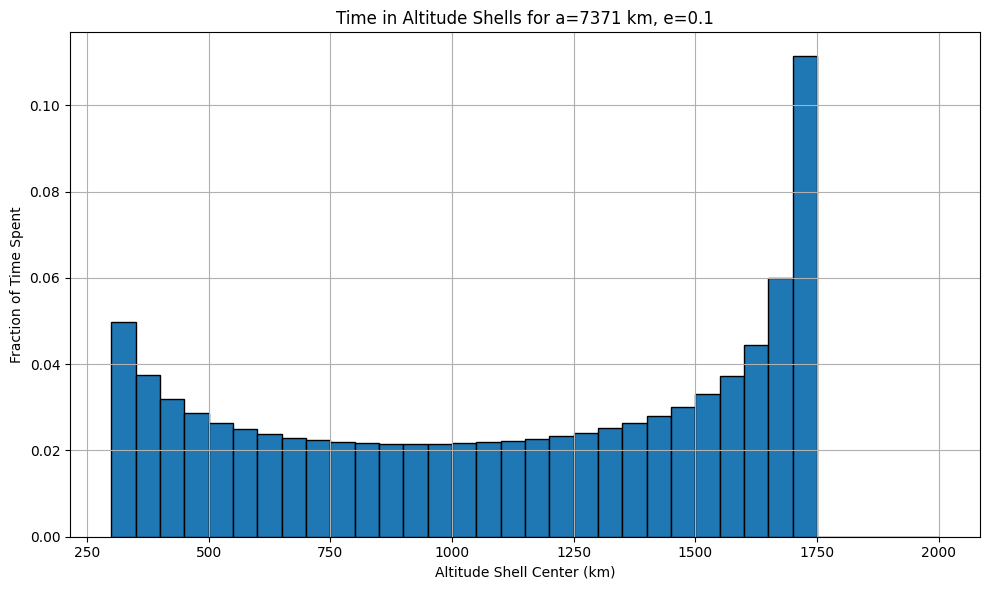

In [7]:
############################
# Test with a simple case
############################

# Test parameters
a_test = 1000 + 6371  # semi-major axis in km
e_test = 0.1   # eccentricity


altitude_shells = np.array([
    300, 350, 400., 450., 500., 550., 600., 650., 700., 750., 800.,
    850., 900., 950., 1000., 1050., 1100., 1150., 1200.,
    1250., 1300., 1350., 1400., 1450., 1500., 1550., 1600.,
    1650., 1700., 1750., 1800., 1850., 1900., 1950., 2000.
])
shell_edges = altitude_shells + 6371 # Convert to sma


# Compute time fractions for test orbit
time_fractions = compute_time_fractions_for_orbit(a_test, e_test, shell_edges)

# sum time_fractions
total_time = np.sum(time_fractions)
print(f"Total time spent in all shells: {total_time:.2f}")

# Compute bin centers for plotting
altitude_bin_centers = (altitude_shells[:-1] + altitude_shells[1:]) / 2

# Plot the results
plt.figure(figsize=(10, 6))
plt.bar(altitude_bin_centers, time_fractions, width=50, align='center', edgecolor='black')
plt.xlabel('Altitude Shell Center (km)')
plt.ylabel('Fraction of Time Spent')
plt.title(f'Time in Altitude Shells for a={a_test} km, e={e_test}')
plt.grid(True)
plt.tight_layout()
plt.show()

# Collisions

[ 1.48000000e+02  6.85100000e+03  4.84438856e+03  4.84438856e+03
  6.85100000e+01 -2.65165043e+00  2.65165043e+00  7.50000000e-02
  1.00000000e+00]
[ 6.00000000e+00  5.00000000e-01 -4.84438856e+03  4.84438856e+03
 -6.85100000e+01  2.65165043e+00 -2.65165043e+00 -7.50000000e-02
  1.00000000e+00]


/Users/indigobrownhall/Code/pyssem/pyssem/utils/collisions/collisions.py:26: RuntimeWarning: divide by zero encountered in log10
  logds = np.log10(d)


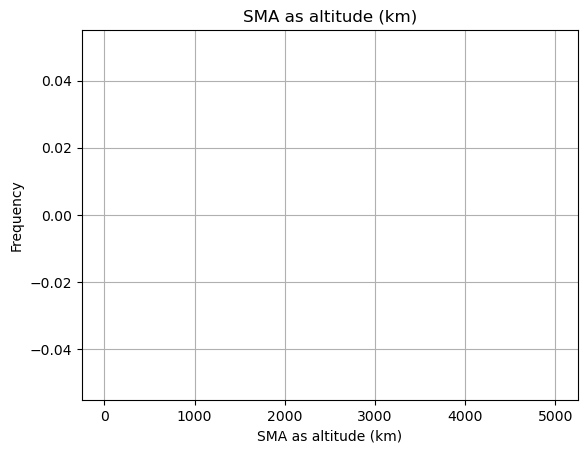

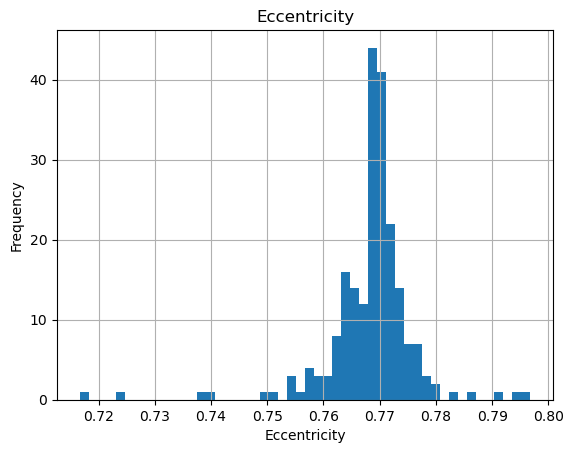

ValueError: Invalid vmin or vmax

Error in callback <function _draw_all_if_interactive at 0x13fbf8c10> (for post_execute), with arguments args (),kwargs {}:


ValueError: Invalid vmin or vmax

ValueError: Invalid vmin or vmax

<Figure size 640x480 with 2 Axes>

In [27]:
import math
from utils.collisions.NASA_SBM_frags import frag_col_SBM_vec_lc2
import numpy as np


SS = 20
R_EARTH = 6371.0  # km
theta = np.radians(45)  # Rotation angle
collision_index = 1
m1 = 148
m2 = 6
r1, r2 = 6851, 0.5
v1 = 7.5  # km/s
v2 = 7.5  # km/s


# Get collision altitude and position magnitude
HMid = np.array([ 426.66666667,  480.        ,  533.33333333,  586.66666667,
    640.        ,  693.33333333,  746.66666667,  800.        ,
    853.33333333,  906.66666667,  960.        , 1013.33333333,
    1066.66666667, 1120.        , 1173.33333333, 1226.66666667,
    1280.        , 1333.33333333, 1386.66666667, 1440.        ,
    1493.33333333, 1546.66666667, 1600.        , 1653.33333333,
    1706.66666667, 1760.        , 1813.33333333, 1866.66666667,
    1920.        , 1973.33333333])

collision_altitude = HMid[collision_index]
r_mag = R_EARTH + collision_altitude

# Define position vectors with slight z offsets
r1_vec = r_mag * np.array([np.cos(theta), np.sin(theta), 0.01])
r2_vec = r_mag * np.array([np.cos(theta + np.pi/2), np.sin(theta + np.pi/2), -0.01])

# Define velocity vectors with orthogonal direction and small z component
v_half = v1 / 2
v1_vec = v_half * np.array([-np.sin(theta), np.cos(theta), 0.02])
v2_vec = v_half * np.array([np.sin(theta), -np.cos(theta), -0.02])

# Compose p1 and p2 inputs
p1_in = np.array([m1, r1, *r1_vec, *v1_vec, 1]) # 1 is the object class (dimensionless)
p2_in = np.array([m2, r2, *r2_vec, *v2_vec, 1])

print(p1_in)
print(p2_in)

param = {
    'req': 6.3781e+03,
    'mu': 3.9860e+05,
    'j2': 0.0011,
    'max_frag': float('inf'),  # Inf in MATLAB translates to float('inf') in Python
    'maxID': 0,
    'density_profile': 'static'
}

altitude = HMid[collision_index] 
earth_radius = 6371  # Earth's mean radius in km
latitude_deg = 45  # in degrees
longitude_deg = 60  # in degrees

# Convert degrees to radians
latitude_rad = math.radians(latitude_deg)
longitude_rad = math.radians(longitude_deg)

# Compute the radial distance from Earth's center
r = earth_radius + altitude

# Calculate the position vector in ECEF coordinates
x = r * math.cos(latitude_rad) * math.cos(longitude_rad)
y = r * math.cos(latitude_rad) * math.sin(longitude_rad)
z = r * math.sin(latitude_rad)

# Return the position vector
x, y, z

# up to correct mass too
if m1 < m2:
    m1, m2 = m2, m1
    r1, r2 = r2, r1

p1_in[0], p2_in[0] = m1, m2 
p1_in[1], p2_in[1] = r1, r2

# remove a from r_x from both p1_in and p2_in
# the initial norm is 1000, so we need to remove the difference
p1_in[2], p1_in[3], p1_in[4] = x, y, z 
p2_in[2], p2_in[3], p2_in[4] = x, y, z
    
LB = 0.1

try:
    debris1, debris2, isCatastrophic = frag_col_SBM_vec_lc2(0, p1_in, p2_in, param, LB)
except Exception as e:
    print("Error in frag_col_SBM_vec_lc2")
    print(f"Exception caught: {e}")

# Assuming debris1 is already defined
idx_a = 0
idx_ecco = 1

# 1. 1D Histogram for SMA (semi-major axis)
plt.figure()
plt.hist((debris1[:, idx_a] - 1) * 6371, bins=np.arange(0, 5001, 100))
plt.title('SMA as altitude (km)')
plt.xlabel('SMA as altitude (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. 1D Histogram for Eccentricity
plt.figure()
plt.hist(debris1[:, idx_ecco], bins=50)
plt.title('Eccentricity')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. 2D Histogram using histogram2d with LogNorm for color scale
plt.figure()
hist, xedges, yedges = np.histogram2d(
    (debris1[:, idx_a] - 1) * 6371, debris1[:, idx_ecco],
    bins=[np.arange(0, 5001, 100), np.arange(0, 1.01, 0.01)]
)

# Avoid any zero counts for logarithmic color scaling
hist[hist == 0] = np.nan  # Replace zeros with NaNs to avoid LogNorm issues

# Plotting the 2D histogram
mappable = plt.imshow(
    hist.T, origin='lower', norm=LogNorm(), 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto'
)
plt.colorbar(mappable, label='Count')
plt.xlim([0, 3000])
plt.xlabel('SMA as altitude (km)')
plt.ylabel('Eccentricity')
plt.title('2D Histogram of SMA and Eccentricity')
plt.grid(True)

[7297.29    0.      0.  ]


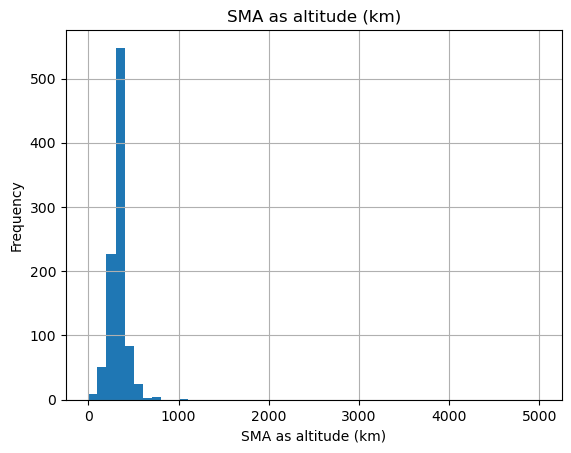

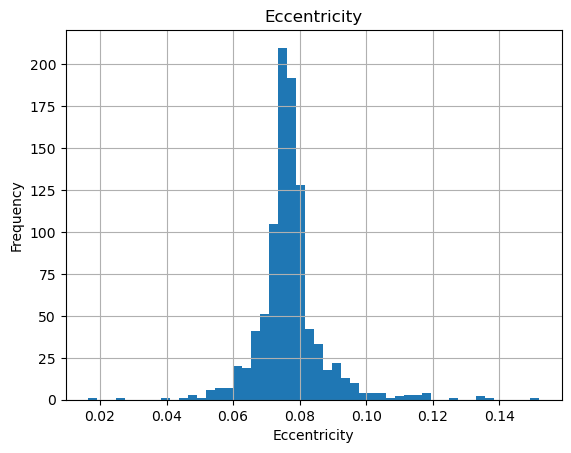

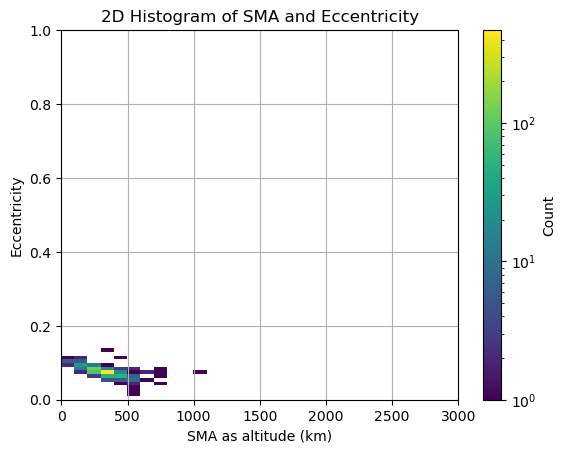

In [ ]:
from matplotlib.colors import LogNorm

def sma_ecc_to_position(a_km, ecc):
    """
    Returns position vector at perigee (true anomaly = 0)
    in orbital plane, assuming 2D motion.
    """
    r_perigee = a_km * (1 - ecc)
    r_vec = np.array([r_perigee, 0, 0])  # km
    return r_vec

# Example
sma = 7371  # km
ecc = 0.01
r_vec = sma_ecc_to_position(sma, ecc)

print(r_vec)

p1_in = np.array([
    1000,  # mass in kg
    5,     # radius in meters
    2600.4,  # r_x in km
    2100.1,  # r_y in km
    6224.8,  # r_z in km
    -5.5,    # v_x in km/s
    -3.0,    # v_y in km/s
    3.8,     # v_z in km/s
    1.0      # object_class (dimensionless)
])

p2_in = np.array([
    100,     # mass in kg
    1,     # radius in meters
    2600.4,  # r_x in km
    2100.1,  # r_y in km
    6224.8,  # r_z in km
    3.2,     # v_x in km/s
    5.4,     # v_y in km/s
    -3.9,    # v_z in km/s
    1.0      # object_class (dimensionless)
])

# Define the param dictionary
param = {
    'req': 6.3781e+03,
    'mu': 3.9860e+05,
    'j2': 0.0011,
    'max_frag': float('inf'),  # Inf in MATLAB translates to float('inf') in Python
    'maxID': 0,
    'density_profile': 'static'
}

# Lower bound (LB)
LB = 0.1  # Assuming this is the lower bound in meters

debris1, debris2, isCatastrophic = frag_col_SBM_vec_lc2(0, p1_in, p2_in, param, LB)

# if debris 1 is empty then contine
if debris1.size == 0:
    print("No debris fragments were generated")
    exit()

idx_a = 0
idx_ecco = 1

# 1. 1D Histogram for SMA (semi-major axis)
plt.figure()
plt.hist((debris1[:, idx_a] - 1) * 6371, bins=np.arange(0, 5001, 100))
plt.title('SMA as altitude (km)')
plt.xlabel('SMA as altitude (km)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 2. 1D Histogram for Eccentricity
plt.figure()
plt.hist(debris1[:, idx_ecco], bins=50)
plt.title('Eccentricity')
plt.xlabel('Eccentricity')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# 3. 2D Histogram using histogram2d with LogNorm for color scale
plt.figure()
hist, xedges, yedges = np.histogram2d(
    (debris1[:, idx_a] - 1) * 6371, debris1[:, idx_ecco],
    bins=[np.arange(0, 5001, 100), np.arange(0, 1.01, 0.01)]
)

# Avoid any zero counts for logarithmic color scaling
hist[hist == 0] = np.nan  # Replace zeros with NaNs to avoid LogNorm issues

# Plotting the 2D histogram
mappable = plt.imshow(
    hist.T, origin='lower', norm=LogNorm(), 
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]], aspect='auto'
)
plt.colorbar(mappable, label='Count')
plt.xlim([0, 3000])
plt.xlabel('SMA as altitude (km)')
plt.ylabel('Eccentricity')
plt.title('2D Histogram of SMA and Eccentricity')
plt.grid(True)

In [53]:
import numpy as np

# Given position vector in km
r_x = 2100.4
r_y = 2100.1
r_z = 6224.8

# Compute magnitude of position vector
r_mag = np.sqrt(r_x**2 + r_y**2 + r_z**2)

# Earth radius in km
R_earth = 6371

# Altitude
altitude_km = r_mag - R_earth

print(f"Altitude: {altitude_km:.2f} km")

Altitude: 526.12 km


In [ ]:
# calculate the position and velocity at the radius of the shell that you are in the perifocal frame
# add on the change in velocity from the NASA SBM for each fragments
# recalculate the specific energy and the specifc angular momentum
# then calculate the new semi-major axis and eccentricity
# then you can rebin the fragments into the new bins